# Model Evaluation

Now that we have selected a model, we will test its performance against the test set.

We can check its time performance and its prediction performance using the RMSE metric. 

We will compare the finetuned random forest against an out of the box random forest.

### Results from this notebook:

- The selected random forest model is capable of predicting MPG of a car within 2.27 RMSE. The 95% confidence interval for the error is \[1.82, 2.65\]. 
- Given the small size of the dataset, model training and prediction are quick.
- Examining the errors made by the model on the training set, we see that the residuals are normally distributed hence overestimation and underestimation are equally likely.
- The model tends to be less accurate for extreme values of MPG.
- Finally, learning curves show that getting more data can help with model performance.


In [1]:
# use black formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# reload module in development mode
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

#### Load training and test sets 

In [3]:
import pandas as pd
from src.utils import split_features_target

df_train = pd.read_pickle("../data/processed/train_processed.pkl")
X_train, y_train = split_features_target(df_train, "mpg")

df_test = pd.read_pickle("../data/processed/test_processed.pkl")
X_test, y_test = split_features_target(df_test, "mpg")

print("train set shape: ", df_train.shape)
print("test set shape:", df_test.shape)

train set shape:  (318, 9)
test set shape: (80, 9)


<IPython.core.display.Javascript object>

#### Load trained model

In [4]:
import pickle

pkl_filename = "../models/pickle_random_forest.pkl"
with open(pkl_filename, "rb") as file:
    rf_tuned = pickle.load(file)

<IPython.core.display.Javascript object>

### Generalization error

Compute RMSE for the test set 

In [5]:
from time import time
import numpy as np
from sklearn.metrics import mean_squared_error

start = time()
rf_tuned.fit(X_train, y_train)
print("Training tuned random forest model took {:.2f} seconds".format(time() - start))
start = time()
y_test_pred = rf_tuned.predict(X_test)
print("Prediction on test set took {:.2f} seconds".format(time() - start))

y_train_pred = rf_tuned.predict(X_train)

print("RMSE train: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print("RMSE test: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

Training tuned random forest model took 0.16 seconds
Prediction on test set took 0.11 seconds
RMSE train: 2.16
RMSE test: 2.27


<IPython.core.display.Javascript object>

- Test errors on the test set errors even better than the validation error given during model selection. The model improved by training on a larger set.
- The difference of RMSE between the training and test sets is small (0.11 MPG). The model doesn't seem to be overfitting.
- Training and prediction are fast. This is not a surprise given their sizes.

### Examine test errors 

#### 95% confindence interval

In [7]:
from scipy import stats

confidence = 0.95
squared_errors = (y_test_pred - y_test) ** 2
ci = np.sqrt(
    stats.t.interval(
        confidence,
        len(squared_errors) - 1,
        loc=squared_errors.mean(),
        scale=stats.sem(squared_errors),
    )
)
print("95% Confidence Interval: [{:.3f}, {:.3f}]".format(ci[0], ci[1]))

95% Confidence Interval: [1.824, 2.646]


<IPython.core.display.Javascript object>

The confidence interval gives an idea of how precise is the estimation of the generalization error. 

Next, we will look at the arrors that our model is making using different diagnostic plots.

In [8]:
# Imports for vizualisation
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
%matplotlib inline
import seaborn as sns

sns.set(font_scale=1.3)
# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

<IPython.core.display.Javascript object>

#### Measured vs Predicted 

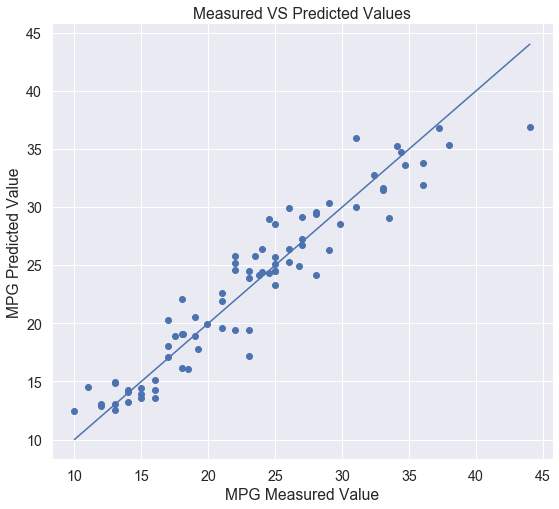

<IPython.core.display.Javascript object>

In [9]:
figsize(8, 8)
fig, ax = plt.subplots()
min_ = y_test.min()
max_ = y_test.max()
ax.scatter(y_test, y_test_pred)
ax.plot([min_, max_], [min_, max_])
plt.xlabel("MPG Measured Value")
plt.ylabel("MPG Predicted Value")
plt.title("Measured VS Predicted Values")

sns.despine()

#### Compare density plots 

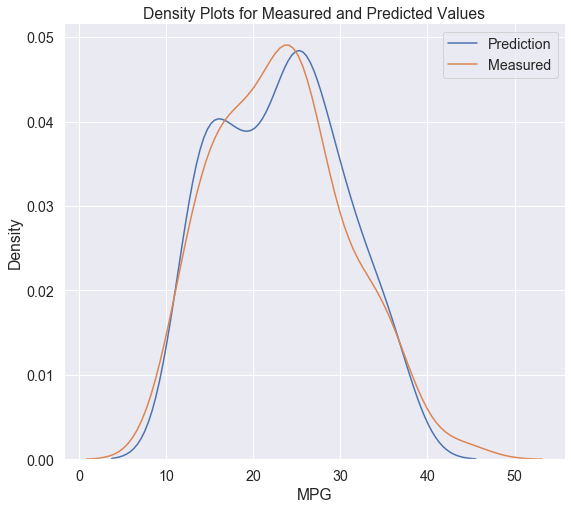

<IPython.core.display.Javascript object>

In [10]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(y_test_pred, label="Prediction")
sns.kdeplot(y_test, label="Measured")

# Label the plot
plt.xlabel("MPG")
plt.ylabel("Density")
plt.title("Density Plots for Measured and Predicted Values")
sns.despine()

Destributions look almost the same. Predicted and measured values peak around the same value (23 MPG). The model apears to be less accurate for extreme values especially the highest values. 

#### Look at residuals 

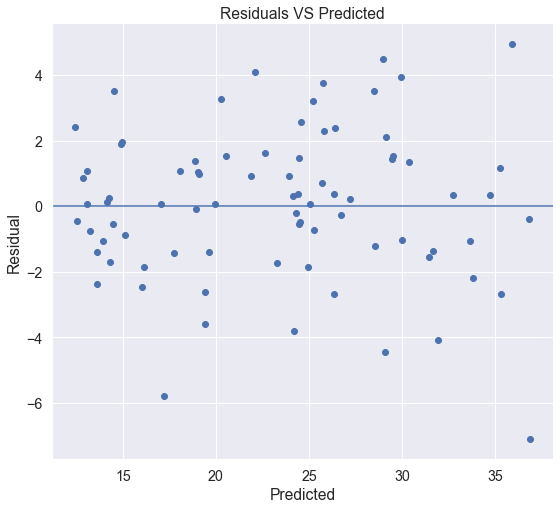

<IPython.core.display.Javascript object>

In [11]:
residual = y_test_pred - y_test
plt.scatter(y_test_pred, residual)
plt.tick_params(axis="both", which="major")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.axhline(y=0)
plt.title("Residuals VS Predicted")
sns.despine()

The residuals vs predicted plot confirms that the model is less accurate for highest values.

#### Distribution of residuals

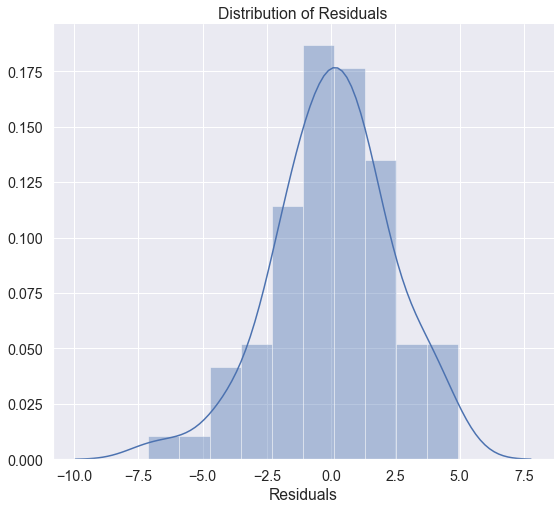

<IPython.core.display.Javascript object>

In [12]:
sns.distplot(residual)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
sns.despine()


Residuals distribution is very close to a normal distribution. This means that the model makes the same amount of error in both directions: predicting higher values or lower values than measured values. 

The left tail indicates that some values have been highly underestimated. 

Imagine that car construction expert seeks a better predictive power.
We could then check the instances where the errors are the largest and try to understand why the model is moking these errors. Usually, this will lead to more feature engineering or to seeking more data.  

## Would more data improve the model?

In this section we will use [leaning curves](https://www.dataquest.io/blog/learning-curves-machine-learning/) to see if getting more data would help our model performance.

#### Training score and test score for diffrent training set sizes

In [14]:
from sklearn.ensemble import RandomForestRegressor

# creat a random forest with the same params than the selected model
rf_lc = RandomForestRegressor().set_params(**rf_tuned.get_params())
train_sizes = np.linspace(36, X_train.shape[0], 10, endpoint=True).astype(int)
train_score = []
test_score = []

for m in train_sizes:
    rf_lc.fit(X_train[:m], y_train[:m])
    train_score.append(mean_squared_error(y_train[:m], rf_lc.predict(X_train[:m])))
    test_score.append(mean_squared_error(y_test, rf_lc.predict(X_test)))

<IPython.core.display.Javascript object>

#### Plot learning curves for the training and test sets

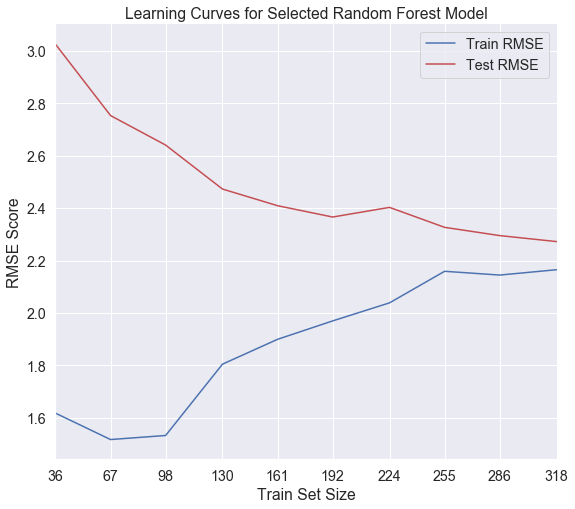

<IPython.core.display.Javascript object>

In [15]:
plt.plot(train_sizes, np.sqrt(train_score), "b", label="Train RMSE")
plt.plot(train_sizes, np.sqrt(test_score), "r", label="Test RMSE")

plt.ylabel("RMSE Score")
plt.xlabel("Train Set Size")
plt.xlim(train_sizes.min(), train_sizes.max())
plt.xticks(train_sizes)
plt.grid(True)
plt.title("Learning Curves for Selected Random Forest Model")
plt.legend(loc="best")
sns.despine()

The learning curves didn't quite converge yet. It is likely that adding more data will help the model make better predictions.